In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=1923a1641895e81b25b2bb379cb6cc8e61f7c3cdbed320c162eedc99ad22f3e6
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils


In [2]:
#####Imports
import os
import imutils #!pip install imutils
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, History

# View and re-organize dataframe

In [3]:
#viewing data
data = pd.read_csv('../input/pokemon-images-and-types/pokemon.csv')
print('Original data')
print(data.head(5))
#view and parse image folder
image_directory = "../input/pokemon-images-and-types/images/images/"
pokemon_filenames = os.listdir(image_directory)
pnames, primary_types = [], []
for path in os.listdir(image_directory):
        #isolating pokemon name
        pokemon_name = path.split('.')[0]
        #isolating pokemon primary type
        row = data[data['Name']==pokemon_name]
        type1 = data['Type1'][int(row.index.values)]
        #appending to new list
        pnames.append(pokemon_name.capitalize())
        primary_types.append(type1)      

Original data
         Name  Type1   Type2
0   bulbasaur  Grass  Poison
1     ivysaur  Grass  Poison
2    venusaur  Grass  Poison
3  charmander   Fire     NaN
4  charmeleon   Fire     NaN


In [4]:
#Create new dataframe/data
pokemon_d = {'Filename':pokemon_filenames, 'Pokemon':pnames, 'Primary_Type':primary_types}
pokemon_data = pd.DataFrame(pokemon_d)
print('Pokemon dataframe shape (row,col):', pokemon_data.shape) #(row, col)
print(pokemon_data.head(5))

Pokemon dataframe shape (row,col): (809, 3)
         Filename     Pokemon Primary_Type
0  roggenrola.png  Roggenrola         Rock
1   pachirisu.png   Pachirisu     Electric
2    drifblim.png    Drifblim        Ghost
3   rhyperior.png   Rhyperior       Ground
4   eelektrik.png   Eelektrik     Electric


# Data prep

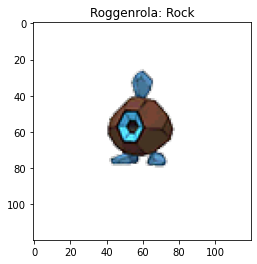

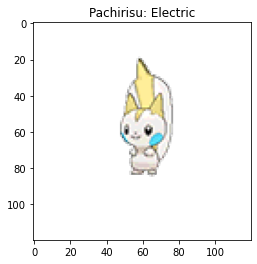

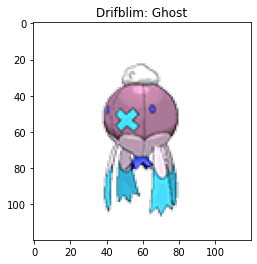

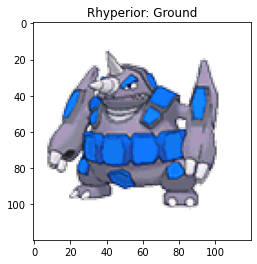

In [5]:
#view and resize images
def preprocess(directory, n, plot = False, save = False, outdir = ''):
    '''
    Given a list of image paths, output n preprocessed images
    directory: folder that contain images
    n: number of images to preprocess
    plot: boolean to display images
    save: boolean to save preprocess images
    outdir: string to save preprocessed images
    '''
    for i in range(n):
        #image = cv2.imread(directory + i)
        image = cv2.imread(directory + pokemon_filenames[i], cv2.IMREAD_UNCHANGED) #change png transparent to white
        image = imutils.resize(image, width = 120) #orignal shape is 120
        (h, w) = image.shape[:2] #omitted channels
        if plot:
            plt.imshow(image)
            plt.title(f"{pnames[i]}: {primary_types[i]}")
            plt.show()
        try:
            if save:
                dest = os.path.join(outdir, pokemon_filenames[i])
                os.makedirs(os.path.dirname(dest), mode = 0o755, exist_ok = True)
                plt.imsave(dest, image)
        except Exception as e:
            print(e)
            print("Error reading image:", pokemon_filenames[i])
    return

preprocess(image_directory, 4, plot=True)

In [6]:
#split using np: 60%, 20%, 20% split for training, validation and test sets
train, validation, test = np.split(pokemon_data, [int(.6*len(pokemon_data)), int(.8*len(pokemon_data))])
train, validation, test = train.reset_index(), validation.reset_index(), test.reset_index()
display(train, validation, test)

,index,Filename,Pokemon,Primary_Type
0,0,roggenrola.png,Roggenrola,Rock
1,1,pachirisu.png,Pachirisu,Electric
2,2,drifblim.png,Drifblim,Ghost
3,3,rhyperior.png,Rhyperior,Ground
4,4,eelektrik.png,Eelektrik,Electric
...,...,...,...,...
480,480,fraxure.png,Fraxure,Dragon
481,481,dratini.png,Dratini,Dragon
482,482,musharna.png,Musharna,Psychic
483,483,kricketot.png,Kricketot,Bug


,index,Filename,Pokemon,Primary_Type
0,485,zeraora.jpg,Zeraora,Electric
1,486,regice.png,Regice,Ice
2,487,guzzlord.jpg,Guzzlord,Dark
3,488,mantyke.png,Mantyke,Water
4,489,solgaleo.jpg,Solgaleo,Psychic
...,...,...,...,...
157,642,nidorina.png,Nidorina,Poison
158,643,cryogonal.png,Cryogonal,Ice
159,644,pancham.png,Pancham,Fighting
160,645,stufful.jpg,Stufful,Normal


,index,Filename,Pokemon,Primary_Type
0,647,arcanine.png,Arcanine,Fire
1,648,herdier.png,Herdier,Normal
2,649,poochyena.png,Poochyena,Dark
3,650,dunsparce.png,Dunsparce,Normal
4,651,pikipek.jpg,Pikipek,Normal
...,...,...,...,...
157,804,quilava.png,Quilava,Fire
158,805,wurmple.png,Wurmple,Bug
159,806,fletchinder.png,Fletchinder,Fire
160,807,phione.png,Phione,Water


# Model

In [7]:
#Designing model
model = VGG16(include_top=False, input_shape=(120,120,3))
flat = Flatten(input_shape=(3,3,512))(model.output)
dense = Dense(512, activation='relu')(flat)
output = Dense(18, activation='softmax')(dense)
#new model
model = Model(inputs=model.inputs, outputs=output)
model.summary()
#plot_model(model)

58892288/58889256 [==============================] - 2s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_______________________________________________________

In [16]:
#Compile model & prep/fit generators
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
datagen = ImageDataGenerator(rescale=1/255)

train_generator = datagen.flow_from_dataframe(
dataframe=train,
directory="../input/pokemon-images-and-types/images/images/",
x_col="Filename",
y_col="Primary_Type",
subset="training",
batch_size=50,
seed=0,
shuffle=True,
classes=['Water','Normal','Grass', 'Bug', 'Fire', 'Electric', 'Ground', 'Poison', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice', 'Flying', 'Dragon', 'Dark', 'Steel'],
target_size=(120,120))

valid_generator = datagen.flow_from_dataframe(
dataframe=validation,
directory="../input/pokemon-images-and-types/images/images/",
x_col="Filename",
y_col="Primary_Type",
subset="training",
batch_size=50,
seed=0,
shuffle=True,
classes=['Water','Normal','Grass', 'Bug', 'Fire', 'Electric', 'Ground', 'Poison', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice', 'Flying', 'Dragon', 'Dark', 'Steel'],
target_size=(120,120))

test_generator = datagen.flow_from_dataframe(
dataframe=test,
directory="../input/pokemon-images-and-types/images/images/",
x_col="Filename",
y_col="Primary_Type",
subset="training",
batch_size=50,
seed=0,
shuffle=True,
classes=['Water','Normal','Grass', 'Bug', 'Fire', 'Electric', 'Ground', 'Poison', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice', 'Flying', 'Dragon', 'Dark', 'Steel'],
target_size=(120,120))

Found 485 validated image filenames belonging to 18 classes.
Found 162 validated image filenames belonging to 18 classes.
Found 162 validated image filenames belonging to 18 classes.


In [18]:
#Fit model
#filepath = "../output/kaggle/working/VGG16_model.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
history = model.fit(train_generator,
                             steps_per_epoch = 10, #num of training images/batch_size
                             epochs = 5,
                             verbose = 2,
                             validation_data = valid_generator,
                             validation_steps= 10) #num of validation images/batch_size
                             #callbacks = [checkpoint]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/5
10/10 - 135s - loss: 1.5636 - accuracy: 0.0825 - val_loss: 1.5678 - val_accuracy: 0.0800
Epoch 2/5
10/10 - 133s - loss: 1.5636 - accuracy: 0.0825 - val_loss: 1.5167 - val_accuracy: 0.1100
Epoch 3/5
10/10 - 136s - loss: 1.5636 - accuracy: 0.0825 - val_loss: 1.5848 - val_accuracy: 0.0700
Epoch 4/5
10/10 - 139s - loss: 1.5636 - accuracy: 0.0825 - val_loss: 1.5678 - val_accuracy: 0.0800
Epoch 5/5
10/10 - 134s - loss: 1.5636 - accuracy: 0.0825 - val_loss: 1.5167 - val_accuracy: 0.1100


# Performance

In [20]:
results = model.evaluate_generator(test_generator, steps=20, verbose=1)
print("loss: ",results[0],"accuracy: ",results[1])

 4/20 [=====>........................] - 9s 2s/step - loss: 1.5253 - accuracy: 0.1049
loss:  1.5252938270568848 accuracy:  0.10493826866149902
